# Parallelism

Computers nowadays all have multiple cores that can run code in parallel. Many codes and algorithms in astronomy can be catagorized as "embarrassingly parallel", meaning that they can easily be split up into multiple tasks that each have little or no dependency on each other. An example of this is running the same image processing steps on multipel files, or computing the likelihood of a bunch of different sets of models. 

Parallelism adds extra complexity to the code, making it harder to debug and maintain. Thus, it is important to consider the relative gain of putting in parallelism versus the extra effort in developing and maintaining that code. For this reason, we also recommend that you keep parallelization code as simple as possible. For many tasks, even the most simple parallelism is sufficient. 

We will discuss a couple options to do parallelism in Python and mention a few other tips:

  1. BLAS/LAPACK
  2. Thread/process pools


In [1]:
import os 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import scipy.ndimage as ndimage
import timeit
import multiprocessing
import astropy.io.fits as fits

## BLAS/LAPACK/ATLAS/MKL

There are packages that automatically parallelize linear algebra routines like matrix dot product or singular value decomposition. BLAS/LAPACK  are the algorithms, and ATLAS, OpenBLAS, or MKL are implementations of them. If you have an Intel processor, you will be using MKL. They are quite useful for when you don't want to write your own parallelization code but want to speed up matrix routines. It requires numpy to be configured for BLAS/MKL properly. Generally if you install numpy with Anaconda, this happens automatically, so we recommend simply doing it this way. These speedups are turned on by default when configured.

However, if you wish to do your own parallelism, make sure to turn this off. Having multiple layers of parallelism will often slow down your code! 

In [2]:
# Check we have BLAS/LAPACK. Notice they are from the MKL library
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jason/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl', 'C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl\\include', 'C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl\\lib', 'C:/Users/Jason/Anaconda3\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/Jason/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl', 'C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl\\include', 'C:\\Program Files (x86)\\IntelSWTools\\compilers_and_libraries_2019.0.117\\windows\\mkl\\lib', 

## Checking Resource Usage

Anytime you are testing parallelized code, it is code to montior your CPU/RAM usage. Monitoring your CPU usage can help you assess if the number of processes being run in parallel is consistent with what you are looking for. Many times, running parallelized code already involves big data sets, and parallelization will use even more memory (you can think of it as trading runtime for memory usage). So have your resource monitor up occasionally when you are developing this code. It is also a great way to debug the code (e.g., identify hanging parallelization that is not finishing). 

In [3]:
import mkl

mat = np.random.random((1000, 1500)) # 1000x1500 matrix

# Use 4 cores to parallelize matrix operations
mkl.set_num_threads(4)
print("4 cores", timeit.timeit("mat.dot(mat.T)", setup="from __main__ import mat", number=100))

# Disable MKL
mkl.set_num_threads(1)
print("1 core", timeit.timeit("mat.dot(mat.T)", setup="from __main__ import mat", number=100))

4 cores 3.8912958
1 core 8.428665800000001


## Running Multiple Python Instances

This might sound very unsophisticated, but it is actually a good choice for many instances. As you will learn before, Python parallelism is not the best, and if tasks are completely independent of each other, running each task as a separate Python process and saving the result as a file is a perfectly reasonable (and simple) option. This is great for batch processes such as bulk processing a bunch of files with some data reduction code.

There are many options to do this: bash script, GNU Parallel, or, as we will focus on today, a master python script. GNU Parallel is also quite useful and is discussed at the end of this notebook. We will focus on using a python script to launch a bunch of python processes because all capabilities of shell scripting (e.g., calling bash commands with the sys module) can be done in Python, and often with much better readability. We will use python to launch a bunch of python processes.

We create a function with an argument `index` that tells each proces what chunk of the task to run. We then create a bunch of processes, give them their chunks, and call `start()` to run them. Afterwards, our master process uses `join()` to wait for each process to finish. It is important to always call `join()` at the end to ensure all processes have finished running! If a process has finished immediately, `join()` will immediately return; if a process has not finished, our master process will sleep until the process it is waiting on has finished. 

In [8]:


def matrix_loop(mat, index):
    # divide up so that we only compute one chunk of the mat.dot(mat.T) matrix
    index_start = mat.shape[0] // 10 * index
    index_end = mat.shape[0] // 10 * (index + 1)
    val  = mat[index_start:index_end].dot(mat.T)
    print("Process {0} complete".format(index))
    # could save value to a shared variable or save to a file to be used later

process_list = []

for i in range(10):
    p = multiprocessing.Process(target=matrix_loop, args=(mat, i))
    process_list.append(p)
    p.start()

for p in process_list:
    p.join()

NameError: name 'mat' is not defined

## Pools

Manually creating threads requires a bunch of upkeep code, which is unnecessary if you are just running over a giant loop. In the spirit of keeping parallelism simple, use high-level parallelization API provided by your programming language whenever possible! It will save you time and effort (Trust me). For dividing up tasks with a for loop, use Python process `Pools`. Essentially, you can give
any number of tasks to a process `Pool` and the processes in the pool will loop through and do each one per your instructions. 

In [5]:
pool = multiprocessing.Pool(processes=4) # creae a pool with 4 worker processes

def matrix_loop(mat, index):
    # divide up so that we only compute one chunk of the mat.dot(mat.T) matrix
    index_start = mat.shape[0] // 10 * index
    index_end = mat.shape[0] // 10 * (index + 1)
    val  = mat[index_start:index_end].dot(mat.T)
    print("Process {0} complete".format(index))
    
    return val # let's return the data this time

pool_jobs = []
for i in range(10):
    job = pool.apply_async(matrix_loop, (mat, i))
    pool_jobs.append(job)
    print("Created job {0}".format(i))

for i, job in enumerate(pool_jobs):
    result = job.get() 
    print("Result {0}".format(i), result.shape)

Created job 0
Created job 1
Created job 2
Created job 3
Created job 4
Created job 5
Created job 6
Created job 7
Created job 8
Created job 9


# Activity: Image Processing

Run the following code to generate some fake data and then run the following image processing function on each fake image and save the resulting data. How fast can you process the data when the images are 1000x1000? What is the speedup from 1 core to multiple cores (is it linear?)?

In [23]:
# note, this cell might take a minute to run.

def generate_fake_data(filename, dims):
    """
    Generates a fake dataframe with random numbers
    
    Args:
        filename (str): file to save the data to
        dims (tuple): (Ny, Nx) pair that species the size of the y and x dimensions
    """
    # some complicated random image generation. Feel free to ignore.
    # coordinate system in fourier spae
    u,v = np.meshgrid(np.fft.fftfreq(dims[1]), np.fft.fftfreq(dims[0]))
    phases = np.random.uniform(0, 2*np.pi, u.shape)
    rho = np.sqrt((u*dims[1])**2 + (v*dims[0])**2)
    # suppress high frequency by a squared exponential
    spectrum = np.exp(-rho**2/(np.max(rho)/50)**2)  * np.exp(1j * phases)
    filtered = np.real(np.fft.ifft2(spectrum))

    fits.writeto(filename, filtered, overwrite=True)


# generate fake data
fileformat = os.path.join("../example_data", "fake_{0}x{1}_{2}.fits")

ny = 1000
nx = 1000
for i in range(25):
    filename = fileformat.format(ny, nx, i)
    generate_fake_data(filename, (ny, nx) )


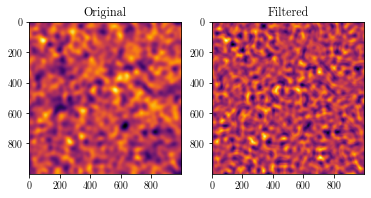

In [24]:
def process_image(frame, filtersize=50):
    """
    Run a high-pass filter on the data. 
    Remove the low spatial frequency (i.e., smooth features) in the image

    Args:
        frame (np.array): a 2-D image to be processed
        fitersize (int): the size of the filter. Features smaller than the filtersize will be preserved

    Returns:
        processed_frame (np.array): a 2-D image after processing
    """
    # run a median filter to smooth the image
    frame_smooth = ndimage.median_filter(frame, filtersize)

    processed_frame = frame - frame_smooth

    return processed_frame

# an example of running this on one image
with fits.open(fileformat.format(ny, nx, 0)) as hdulist:
    data = np.copy(hdulist[0].data)


    filt_data = process_image(data)

    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_subplot(121)
    ax1.imshow(data, cmap="inferno")
    ax1.set_title("Original")
    ax2 = fig.add_subplot(122)
    ax2.imshow(filt_data, cmap="inferno")
    ax2.set_title("Filtered")

#### Activity:
# write and time some code that does this in parallel. How does the performance increase as you increase the number of processes you use?
# we recommend you use multiprocessing pool for this task

# Parallelism Extended Cut

There is a lot of talk about in paralleism are we are just scratching the surface. The above concepts _shoud_ cover the majority of paralelism use cases. However, here are some good things to know.


## Do you really need parallelism

We already emphasized this above, but parallelism adds complexity. Try avoiding parallelization until it is necessary. If some code takes 10 minutes to run, but you only need to run it once per week, is it worth parallelization? The programming and upkeep costs may not be worth it. Parallelism also makes it hard to debug: we cannot attach the python debugger on other Python processes meaning they often crash with no error message as to why. GNU Parallel (below) is an alternative to writing more complicated code.

## GNU Parallel

If you have a script that you want to run on multiple times (e.g., on multiple files), you don't need to write Python parallelization. We can use the `parallel` package that can be installed on UNIX systems to handle the parallelization. For example, if we can process a single file by running on the command line:

    python process.py file_01.fits

Then we can run it on `file_01.fits` to `file_99.fits` by running on the command line:

    parallel python process.py ::: file_{00..99}.fits


## Threads vs Processes
Python has two parallelization modules: `multiprocessing` and `multithreading`. What's the difference? Why do we only use `multiprocessing`?

Threads and processes are both tasks that your computer CPUs are run in parallel. Threads share the same memory, whereas processes do not. Processes have to communicate themselves with shared variables (see below) or via a slower I/O method (writing to files, communicating overn websockets). Most languages use threads to parallelism computations because sharing the same memory is very convenient and saves on resources. However, Python has the "Global Intepreter Lock" (GIL) that allows only one thread to run at a time (for complciated consistency reasons). Generally, parallelism in astronomy involves computationally intensive tasks so only one of them being able to run at a time would defeat the purpose. That's why you will generally only see multiprocessing in astronomy-related software development.

Threads are more frequently seen outside of astronomy, but it is generally useful for "I/O bound tasks" as opposed to the "CPU bound tasks" that we usually encounter in astronomy. Anytime you have tasks with a lot of sleeping/waiting time such as if you have multiple web API queries (e.g., multiple database queries) or waiting for files to be created, threads are a better choice because they use less memory and they can access all of your variables instead of having to define shared variables.

The one notable exception is that `numpy` functions that call C code releases the GIL. This means if your code is dominated by `numpy` matrix operations such as dot product, then you can actually use threads with minimal increase in runtime.

## Shared Variables

Processes do not by default share memory. For processes to read/write/access the same variables, we have to declare shared memory. Python `multiprocessing` provides nearly all shared memory structure that you should be using: queues and arrays. Queues allow for interprocess communication. Arrays allow for large datasets to be accessed by multiple processes without needing to duplicate them (possibly saving a lot of memory usage). Use these special arrays and queues becasue they are automatically synchronized between processes and do not require synchronization code, which is generally low-level synchronization that we should avoid programming unless we absolutely need it. 
